In [1]:
import sys,os,os.path
os.environ['OMP_NUM_THREADS']='4'

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import theano as th
from theano import tensor as tt
from theano.tensor.shared_randomstreams import RandomStreams as RandomStreams
from theano.tensor.shared_randomstreams import raw_random

In [3]:
rng = RandomStreams()

In [4]:
th.config.floatX = 'float64'
th.config.openmp = False
#th.config.openmp_elemwise_minsize = 10000
#th.config.cxx = 'g++-6'
#th.config.exception_verbosity = 'high'

In [5]:
N_particles = 1000
transition_std = 0.2
emission_std = 0.4
def transition_det(x):
    return x/2 + (10*x)/(1+x)

def transition(x):
    return transition_det(x) + rng.normal(std=transition_std, size=x.shape)

def emission_det(x):
    return x**2/10

def emission(x):
    return emission_det(x) + rng.normal(std=emission_std, size=x.shape)

In [6]:
inp = tt.vector(name='default input vector')

In [7]:
get_transition = th.function([inp], transition(inp), allow_input_downcast=True)
get_emission = th.function([inp], emission(inp), allow_input_downcast=True)

In [8]:
latent = [19.]
for _ in range(1000):
    latent.append(get_transition(np.array([latent[-1]]))[0])

observe = get_emission(np.array(latent))

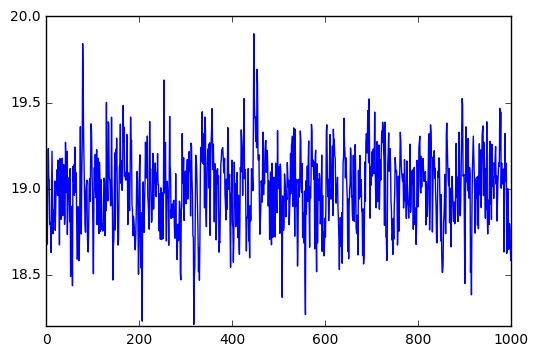

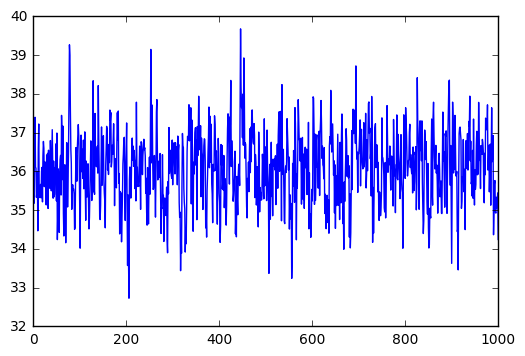

In [9]:
plt.plot(latent)
plt.show()
plt.plot(observe)
plt.show()

In [10]:
def prob(x, observation):
    pre = tt.exp(-(emission_det(x) - observation)**2/(2*emission_std**2))
    return pre/pre.sum()

def resample(x, probs):
    return rng.choice(a=tt.arange(x.shape[0]), p=probs, replace=True, size=(N_particles,), dtype='int64').T

def update(x):
    res, updates = th.scan(transition, non_sequences=x, n_steps=10)
    return res.reshape((-1,))[:N_particles]

In [11]:
observe_th = th.shared(np.array(observe), name='observe')
init_sample = th.shared(np.random.normal(scale=3,size=(N_particles,)), name='current sample')

In [12]:
def filt_iter (observation, x, y):
    probs = prob(y,observation)
    res = resample(y,probs)
    probs = probs[res]
    return y[res], update(x), probs

results, updates = th.scan(filt_iter,
                           outputs_info = [{'initial':init_sample[:N_particles]},{'initial':init_sample}, None],
                           sequences=observe_th)
results = [results[0], results[2]]

In [13]:
filtered = th.function([], results, updates=updates)

In [14]:
filt_distrib, filt_distrib_probs = filtered()

In [15]:
filt_distrib.shape

(1001, 1000)

In [16]:
filt_distrib = np.array(filt_distrib)
filt_distrib = np.sort(filt_distrib, axis=1)

In [17]:
trajnum = 270

In [18]:
def pxtp1x (x2,x1):
    return tt.exp(-(transition_det(x1)-x2)**2/(2*transition_std**2))

In [19]:
def back_filter(xtp1, x, wt):
    unnorm = pxtp1x(xtp1.reshape((-1,1)), x.reshape((1,-1)))#*wt.reshape((1,-1))
    return unnorm/(unnorm.sum(axis=1).reshape((-1,1)))

In [20]:
seed = np.random.choice(filt_distrib[-1], p=filt_distrib_probs[-1]/filt_distrib_probs[-1].sum(), size=trajnum)
seed = th.shared(seed, name='trajectory seed')
filt_distrib_th = th.shared(filt_distrib, name='filtered distribution')
filt_distrib_probs_th = th.shared(filt_distrib_probs, name='filtered distrib probabilities')

In [21]:
def interfun(x, wt, xtp1):
    bf = back_filter(xtp1, x, wt)
    results, updates = th.map(lambda prob: rng.choice(a=x, p=prob, size=(1,), dtype=th.config.floatX), bf)
    return results.reshape((-1,)), updates

In [22]:
results, updates = th.scan(interfun, 
                           outputs_info=seed,
                           go_backwards=True,
                           sequences=[filt_distrib_th[:-1], 
                                      filt_distrib_probs_th[:-1]])

In [23]:
smoothed_traj = th.function([], results[::-1], updates=updates)

In [24]:
%time smoothed = smoothed_traj()

CPU times: user 30.6 s, sys: 70.5 ms, total: 30.6 s
Wall time: 30.7 s


In [25]:
smoothed.shape

(1000, 270)

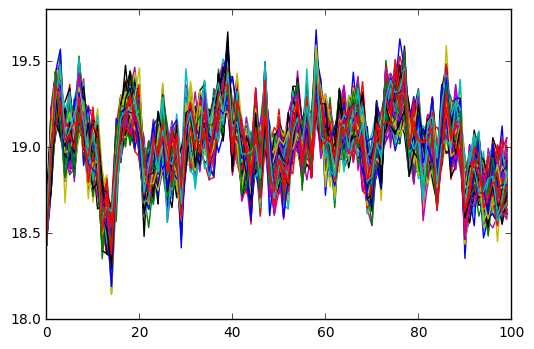

In [30]:
#plt.plot(np.mean(smoothed[-100:], axis=1), color='blue')
plt.plot(smoothed[-100:])
plt.plot(latent[-101:-1], color='red')
plt.show()

In [27]:
latent = np.array(latent)

In [28]:
np.sqrt(np.mean((latent[-201:-1] - np.mean(smoothed[-200:], axis=1))**2))

0.088482698805559784

In [29]:
np.sqrt(np.mean((latent[-200:] - np.mean(filt_distrib[-200:], axis=1))**2))

0.088238084218452056

In [31]:
filt_distrib = filt_distrib[1:]

In [32]:
smm = []
for i in range(smoothed.shape[0]):
    smm.append(np.random.choice(filt_distrib[i], p=smoothed[i], size=100, replace=True))
smm = np.array(smm)
smm = np.sort(smm, axis=1)

ValueError: a and p must have same size

In [28]:
filt_distrib.shape

(1000, 1000)

In [29]:
p = 0.15
dfilt = int(p*filt_distrib.shape[1])
dsm = int(p*smm.shape[1])

In [30]:
latent = np.array(latent)

Filtered:


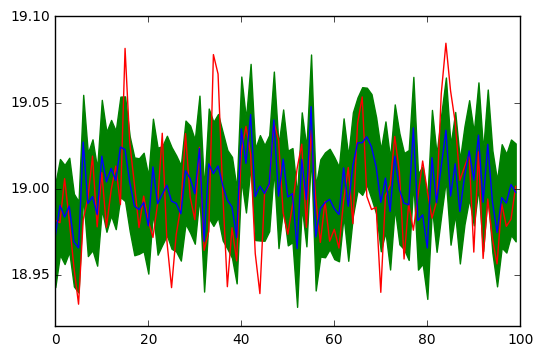

Smoothed:


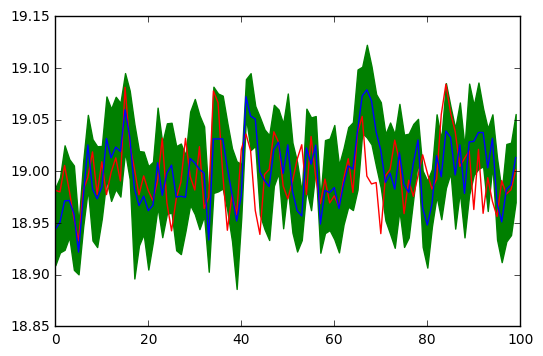

Smoothed MSE: 0.934269644573
Filtered MSE: 0.707566120256


In [31]:
print('Filtered:')
plt.fill_between(range(100),filt_distrib[-100:,dfilt],filt_distrib[-100:,-dfilt],color='green')
plt.plot(latent[-100:],color='red')
plt.plot(filt_distrib.mean(axis=1)[-100:], color='blue')
plt.show()

print('Smoothed:')
plt.fill_between(range(100),smm[-100:,dsm], smm[-100:,-dsm], color='green')
plt.plot(latent[-100:],color='red')
plt.plot(np.mean(smm[-100:], axis=1), color='blue')
plt.show()

print( 'Smoothed MSE: {}'.format( np.sqrt(((np.mean(smm[-600:], axis=1) - latent[-600:])**2).sum())) )
print( 'Filtered MSE: {}'.format( np.sqrt(((np.mean(filt_distrib[-600:],axis=1) - latent[-600:])**2).sum())) )

In [32]:
latent.shape

(1001,)